# PGA Data Exploration

Notebook for the exploration of the PGA data set and first pass evaluation of features, relationships and models

In [9]:
import os 
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize

from workbench.projects.pga.data.stat_downloader import StatDownloader
from workbench.projects.pga.data.event_downloader import EventDownloader
from workbench.projects.pga.data.data_reader import DataReader

# No warnings about setting value on copy of slice
pd.options.mode.chained_assignment = None

data_path_base = os.path.join(os.getenv('DATA'), 'pydata', 'projects', 
                              'pga', 'processed_data')

In [6]:
# Read in from file
file_name = 'base_data1.csv'
data_csv_path = os.path.join(data_path_base, file_name)
base = pd.read_csv(data_csv_path)

In [ ]:
# Load new set of stats/results
sample_stat_ids = ['127', '101', '102', '129', '158', '103', '111', '119',
                   '115', '104', '190', '130', '413', '398', '426']

sample_tourn_ids = ['63', '64', '65', '66', '67', '70', '79', '73',
                    '74', '81', '84', '85', '89', '94']
dr = DataReader()
sdata = dr.build_stat_df(stat_ids=sample_stat_ids, min_year=1999)
rdata = dr.build_result_df(tourn_ids=sample_tourn_ids, min_year=2000)
base = dr.build_base_data(sdata, rdata, backfill_stats=True)

In [21]:
feature_cols = [x for x in base.columns if x.find('rank_') == 0]
print(base.columns, '\n')
base.head()

Index(['player_name', 'year', 'event_id', 'tourn_id', 'result', 'result_pct',
       'end_date', 'rank_127', 'rank_101', 'rank_102', 'rank_129', 'rank_158',
       'rank_103', 'rank_111', 'rank_119', 'rank_115', 'rank_104', 'rank_190',
       'rank_130', 'rank_413', 'rank_398', 'rank_426'],
      dtype='object') 



player_name  year  event_id  tourn_id  result  result_pct   end_date  \
0  Aaron Baddeley  2004       324        63    40.0    0.481928  2/15/2004   
1  Aaron Baddeley  2004       364        64    71.0    1.000000   2/1/2004   
2  Aaron Baddeley  2004       404        65    86.0    1.000000   2/8/2004   
3  Aaron Baddeley  2004       444        66    32.0    0.405063  2/22/2004   
4  Aaron Baddeley  2004       484        67    21.0    0.283784  3/14/2004   

   rank_127  rank_101  rank_102    ...     rank_103  rank_111  rank_119  \
0      59.0      82.0     186.0    ...        183.0      46.0       1.0   
1      59.0      82.0     186.0    ...        183.0      46.0       1.0   
2      59.0      82.0     186.0    ...        183.0      46.0       1.0   
3      59.0      82.0     186.0    ...        183.0      46.0       1.0   
4      59.0      82.0     186.0    ...        183.0      46.0       1.0   

   rank_115  rank_104  rank_190  rank_130  rank_413  rank_398  rank_426  
0       3.0       3.0     141.0      63.0       1.0       1.0      12.0  
1       3.0       3.0     141.0      63.0       1.0       1.0      12.0  
2       3.0       3.0     141.0      63.0       1.0       1.0      12.0  
3       3.0       3.0     141.0      63.0       1.0       1.0      12.0  
4       3.0       3.0     141.0      63.0       1.0       1.0      12.0  

[5 rows x 22 columns]

### Two potential response columns: (1) integer positionn finish and (2) percentile of finish (adjusts for different field sizes)

In [8]:
print(base.result.head(), '\n')
print(base.result.describe(), '\n')
print(base.result_pct.head(), '\n')
print(base.result_pct.describe(), '\n')

0    40.0
1    71.0
2    86.0
3    32.0
4    21.0
Name: result, dtype: float64 

count    29157.000000
mean        52.712007
std         26.441038
min          1.000000
25%         29.000000
50%         63.000000
75%         75.000000
max         91.000000
Name: result, dtype: float64 

0    0.481928
1    1.000000
2    1.000000
3    0.405063
4    0.283784
Name: result_pct, dtype: float64 

count    29157.000000
mean         0.695599
std          0.342480
min          0.010989
25%          0.387500
50%          0.851351
75%          1.000000
max          1.000000
Name: result_pct, dtype: float64 



Text(0.5, 1.0, 'Result Distribution')

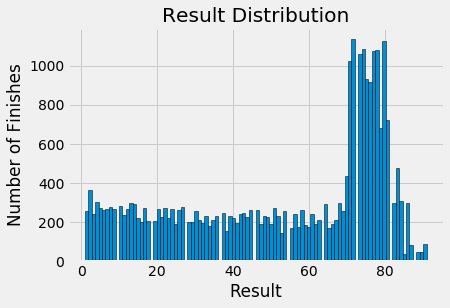

In [11]:
%matplotlib inline
# Histogram of the result and result_pct
plt.style.use('fivethirtyeight')
plt.hist(base['result'], bins = 100, edgecolor = 'k')
plt.xlabel('Result')
plt.ylabel('Number of Finishes')
plt.title('Result Distribution')

Text(0.5, 1.0, 'Result Percentile Distribution')

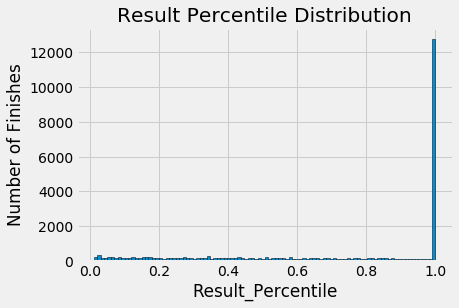

In [15]:
%matplotlib inline
# Histogram of the result and result_pct
plt.style.use('fivethirtyeight')
plt.hist(base['result_pct'], bins = 100, edgecolor = 'k')
plt.xlabel('Result_Percentile')
plt.ylabel('Number of Finishes')
plt.title('Result Percentile Distribution')

### Features

~/.pyenv/versions/anaconda3-5.2.0/envs/ana36/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


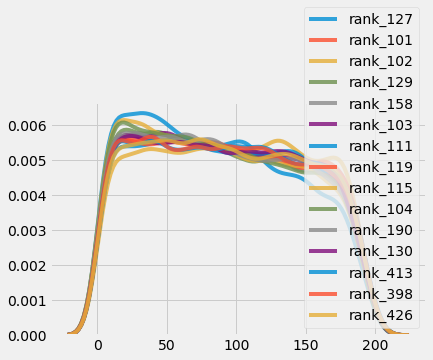

In [18]:
for fc in feature_cols:
    # Density plot of Energy Star scores
    sns.kdeplot(base[fc], label = fc, shade = False, alpha = 0.8)

Many features show a positive correlation with result, and log/result_pct do not seem to be better correlated than plain result.  Correlations are positive which makes sense as well

In [30]:
# Find all correlations and sort
base['log_res_pct'] = np.log(base.result_pct)
corr_res = base.corr()['result']
corr_res_pct = base.corr()['result_pct']
corr_log_res_pct = base.corr()['result_pct']
corr_df = pd.concat([corr_res, corr_res_pct, corr_log_res_pct], axis=1)
corr_df.sort_values('result', inplace=True)
corr_df

result  result_pct  result_pct
tourn_id    -0.028418   -0.021485   -0.021485
event_id    -0.028107   -0.021592   -0.021592
rank_102     0.010090    0.009227    0.009227
year         0.025055    0.011492    0.011492
rank_398     0.038236    0.035983    0.035983
rank_413     0.038351    0.036081    0.036081
rank_119     0.041323    0.038921    0.038921
rank_426     0.053322    0.050263    0.050263
rank_111     0.090123    0.086219    0.086219
rank_130     0.109497    0.105583    0.105583
rank_101     0.111734    0.111932    0.111932
rank_129     0.120100    0.118225    0.118225
rank_104     0.123713    0.119070    0.119070
rank_103     0.146486    0.144620    0.144620
rank_158     0.147254    0.145081    0.145081
rank_190     0.150463    0.148481    0.148481
rank_115     0.152268    0.148043    0.148043
rank_127     0.247166    0.237687    0.237687
log_res_pct  0.900666    0.918074    0.918074
result_pct   0.980721    1.000000    1.000000
result       1.000000    0.980721    0.980721

Feature cross correlation does not seem to bad with the exception of 413/398 which are One Putt % and One Putts Per Round which makes sense

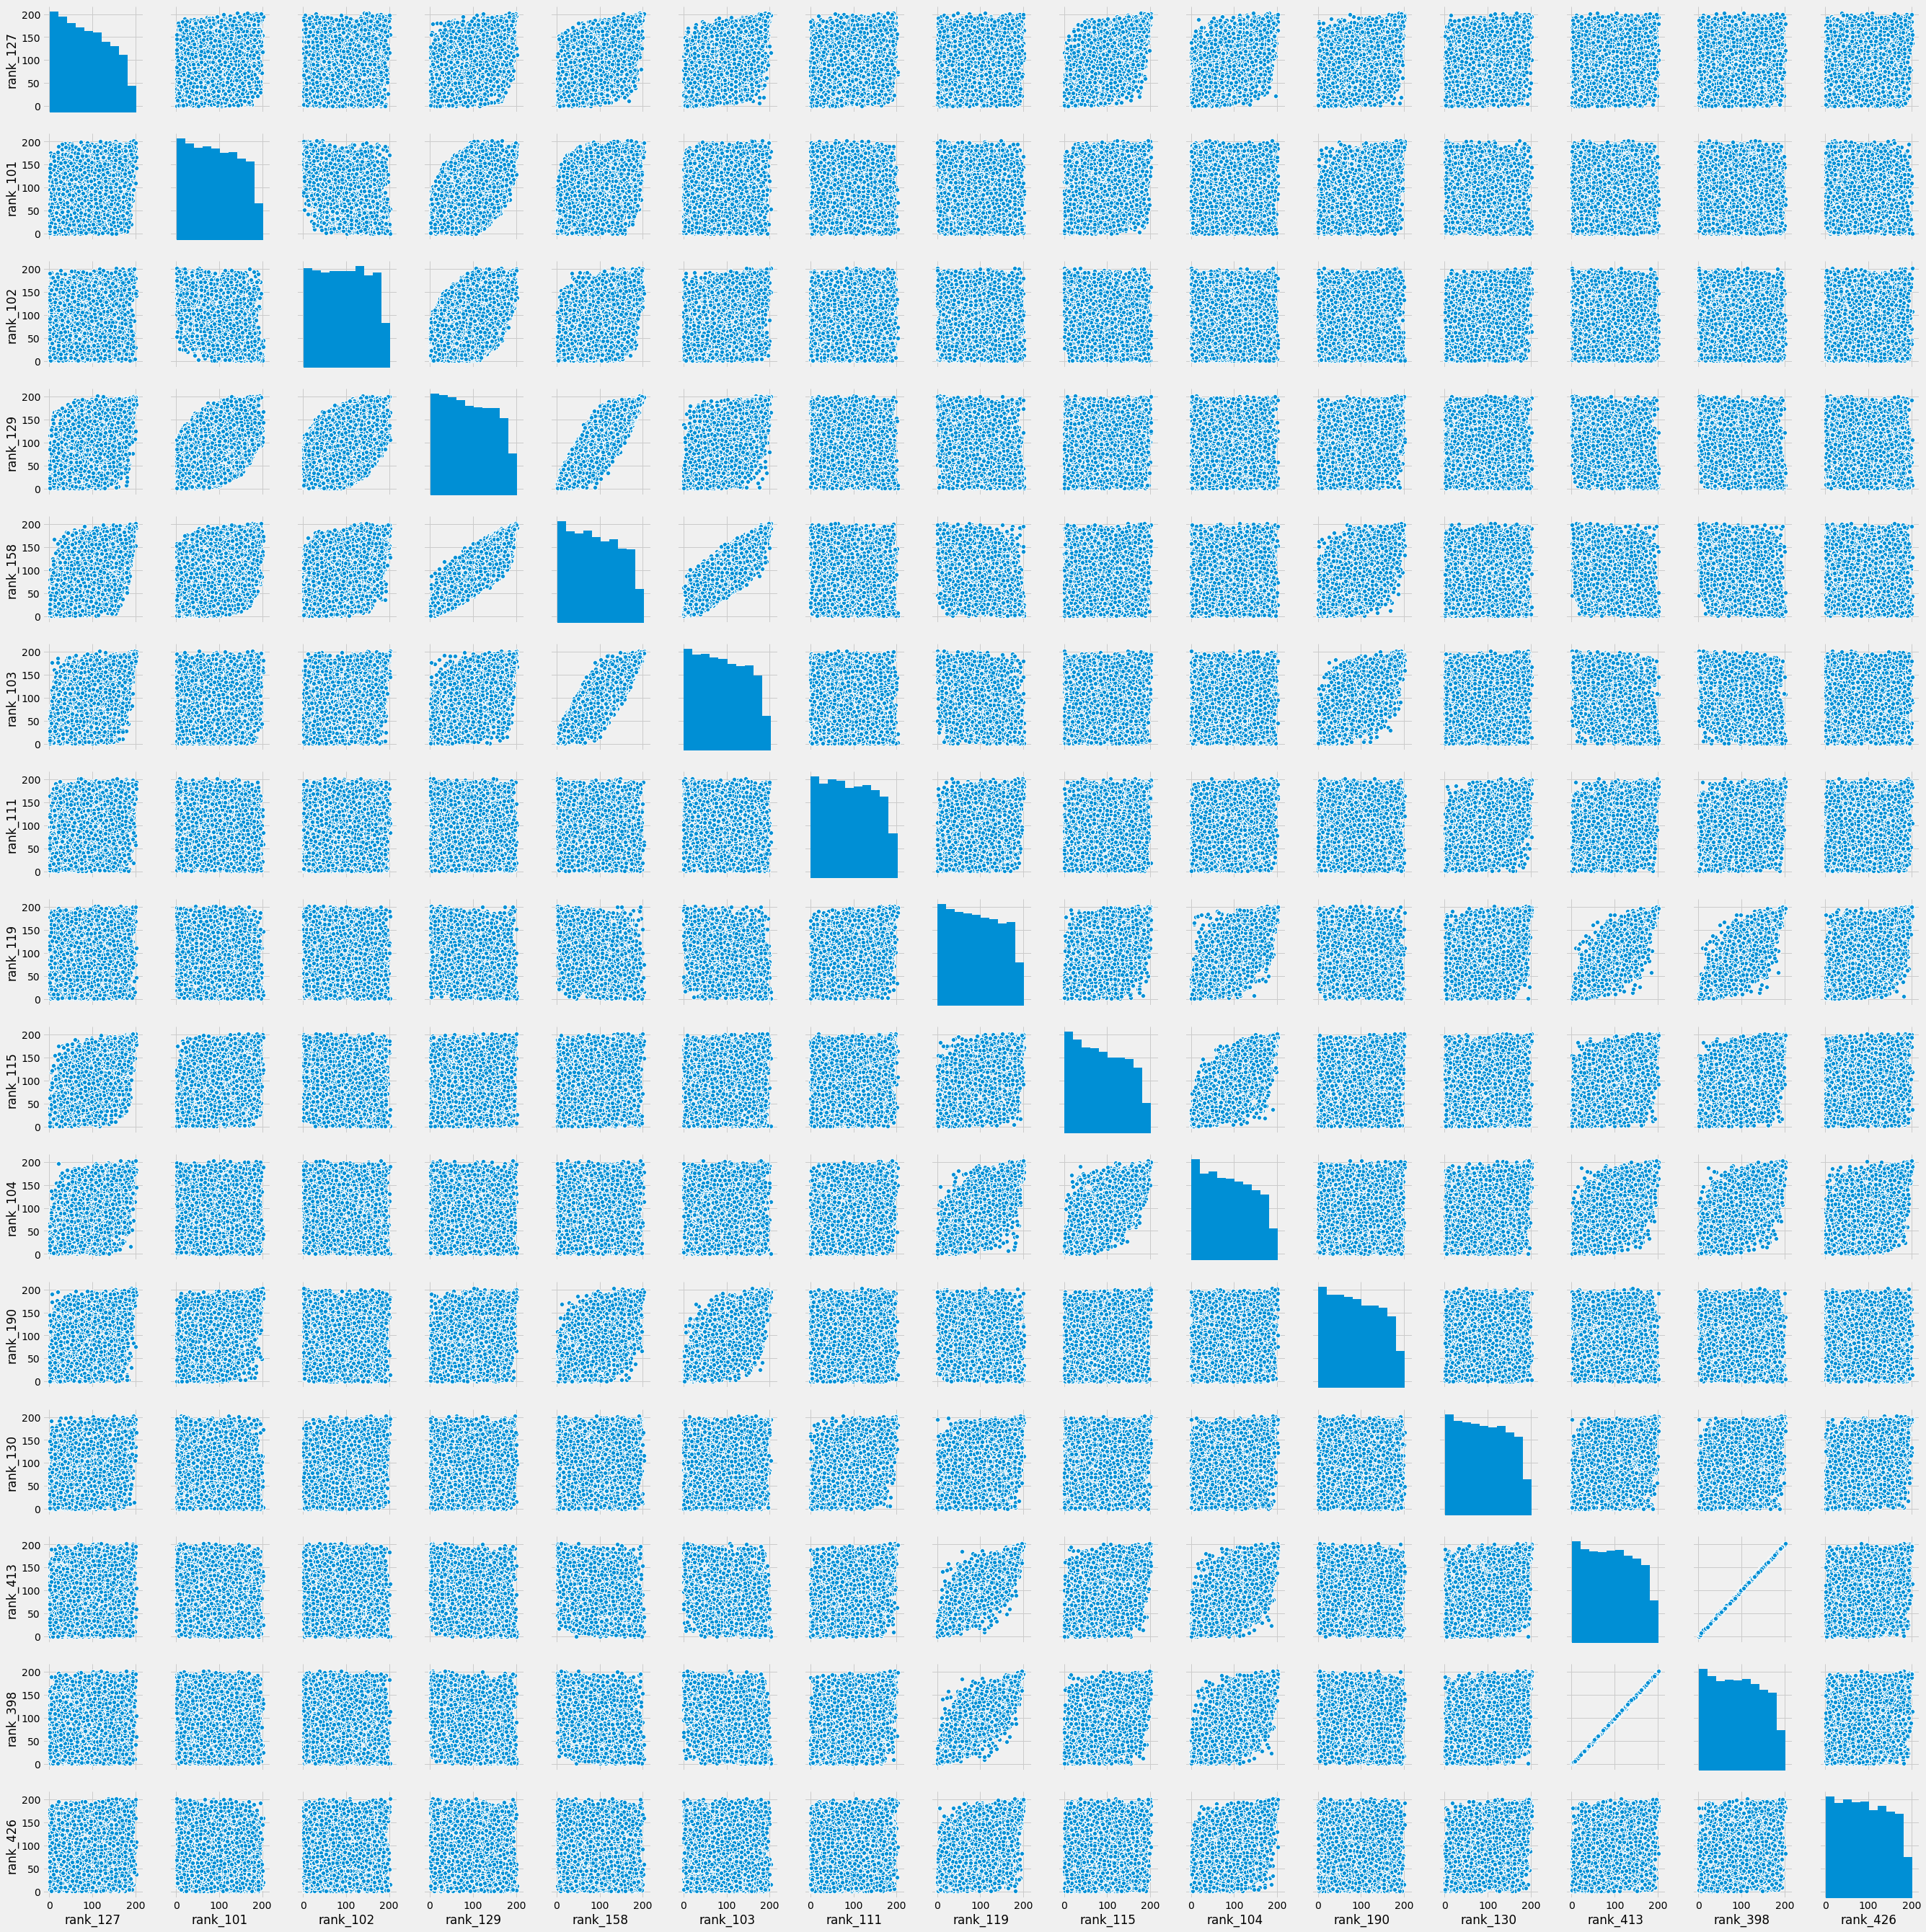

In [31]:
sns.pairplot(base[feature_cols])

In [50]:
stat_info

stat_id  cat_abbr            cat_name max_year min_year n_files  \
15      127  RPTS_INQ     Points/Rankings     2019     1980      40   
38      101  ROTT_INQ         Off the Tee     2019     1980      40   
57      102  ROTT_INQ         Off the Tee     2019     1980      40   
71      129  ROTT_INQ         Off the Tee     2019     1980      40   
72      158  ROTT_INQ         Off the Tee     2019     1980      40   
86      103  RAPP_INQ  Approach the Green     2019     1980      40   
98      190  RAPP_INQ  Approach the Green     2019     1992      28   
186     111  RARG_INQ    Around the Green     2019     1980      40   
191     130  RARG_INQ    Around the Green     2019     1992      28   
216     413  RPUT_INQ             Putting     2019     1992      28   
228     398  RPUT_INQ             Putting     2019     1992      28   
230     426  RPUT_INQ             Putting     2019     1992      28   
282     119  RPUT_INQ             Putting     2019     1980      40   
291     104  RPUT_INQ             Putting     2019     1986      34   
293     115  RPUT_INQ             Putting     2019     1980      40   

                             stat_label  \
15                    All-AroundRanking   
38                      DrivingDistance   
57            DrivingAccuracyPercentage   
71                         TotalDriving   
72                         BallStriking   
86         GreensinRegulationPercentage   
98             GIRPercentagefromFairway   
186                  SandSavePercentage   
191                          Scrambling   
216                  One-PuttPercentage   
228                     1-PuttsperRound   
230                     3-PuttAvoidance   
282                       PuttsPerRound   
291                      PuttingAverage   
293  BirdieorBetterConversionPercentage   

                                  stat_name  
15                       All-Around Ranking  
38                         Driving Distance  
57              Driving Accuracy Percentage  
71                            Total Driving  
72                            Ball Striking  
86          Greens in Regulation Percentage  
98              GIR Percentage from Fairway  
186                    Sand Save Percentage  
191                              Scrambling  
216                     One-Putt Percentage  
228                       1-Putts per Round  
230                        3-Putt Avoidance  
282                         Putts Per Round  
291                         Putting Average  
293  Birdie or Better Conversion Percentage

In [48]:
from workbench.utils.feature_selection import filter_df_corr
features = base[feature_cols].copy()
y = base['result'].copy()
noncorr_features = filter_df_corr(features, .8, print_drops=True)
noncorr_features.shape
noncorr_cols = noncorr_features.columns

rank_129 | rank_158 | 0.9
rank_158 | rank_103 | 0.9
rank_119 | rank_413 | 0.86
rank_119 | rank_398 | 0.86
rank_413 | rank_398 | 1.0


In [51]:
drop_cols = set(feature_cols) - set(noncorr_cols)
base2 = base.drop(columns=drop_cols)
file_name = 'base_data2.csv'
data_csv_path = os.path.join(data_path_base, file_name)
base2.to_csv(data_csv_path, index=False)

## Modeling Approaches

In [52]:
# Read in from file
file_name = 'base_data2.csv'
data_csv_path = os.path.join(data_path_base, file_name)
base = pd.read_csv(data_csv_path)
base.columns

In [64]:
from sklearn.model_selection import train_test_split
feature_cols = [x for x in base.columns if x.find('rank_')==0]
features = base[feature_cols].copy()
targets = base[['result']].copy()
# Split into 70% training and 30% testing set
X, X_test, y, y_test = train_test_split(features, targets, test_size = 0.2, random_state = 123)
print(X.shape)
print(X_test.shape)
print(y.shape)
print(y_test.shape)

(23325, 11)
(5832, 11)
(23325, 1)
(5832, 1)


In [66]:
# Baseline Using Mean Absolute Error 
def mae(y_true, y_pred):
    return np.mean(abs(y_true - y_pred))
baseline_pred = np.median(y)
print('The baseline guess is a score of %0.2f' % baseline_pred)
print("Baseline Performance on the test set: MAE = %0.4f" % mae(y_test, baseline_pred))

The baseline guess is a score of 63.00
Baseline Performance on the test set: MAE = 22.5166
